In [3]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'TJ-BG-AT-SX-CC-MV'
board_name = ['Tech_job','Boy-Girl','AllTogether','sex','C_Chat','movie']
board_dict_index = {'Tech_job':0,'Boy-Girl':1,'AllTogether':2,'sex':3,'C_Chat':4,'movie':5}

max_word_length = 500
min_word_length = 100
max_title_length = 20
words_limit = 30000
label_newnum = len(board_name)

GO_id = '<go>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import jieba
import json

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_label = []
text_generator = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character.
    text = GO_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Split titles to words by Jieba.
    title_name.encode('utf-8-sig')
    title_jieba = jieba.cut(title_name, cut_all=False)
    title_name = GO_id
    word_length = 0
    for word in title_jieba:
        word_length += 1
        title_name = title_name + ' ' + word.lower()
    else:
        title_name = title_name + ' ' + EOS_id

    text_content.append(text)
    text_label.append(board_dict_index[this_board_name])
    text_generator.append(title_name)
    file.close()

# Build vocabulary and convert content to sequence by Keras tool.
tokenizer = Tokenizer(num_words=words_limit, 
                      filters='!"#$%&()*+,×-./:;=?@[\\]^_`{|}~\t\n　，。！：；、？＜＞﹝﹞「」『』（）｛｝［］【】《》〖〗﹙﹚“”‘’＼﹨｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％⌒‿︵︷︹︻︽︿﹁﹃︶︸︺︼︾﹀﹂﹄＆～§◎．˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔', 
                      lower=True,
                      split=" ")
                      #oov_token=UNK_word)
tokenizer.fit_on_texts(text_content+text_generator)
vocab_sort = tokenizer.word_index
vocab_counts = tokenizer.word_counts
vocab_docs = tokenizer.word_docs

print('Vocabulary size after jieba: ', len(vocab_sort))
vocab = {}
vocab_reverse = {}
vocab_keys = list(vocab_sort.keys())
for vocab_word in vocab_keys:
    vocab_index = vocab_sort[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
        vocab[vocab_keys[vocab_index-1]] = vocab_index
        if vocab_index % 1000 == 0 or vocab_index < 100:
            print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                  vocab_counts[vocab_word], vocab_docs[vocab_word])
else:
    #vocab[GO_id] = words_limit + 1
    #vocab_reverse[words_limit + 1] = GO_id
    #vocab[EOS_id] = words_limit + 2
    #vocab_reverse[words_limit + 2] = EOS_id
    vocab[UNK_id] = words_limit + 3
    vocab_reverse[words_limit + 3] = UNK_id

# Save vocabulary information.
with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_sort))
with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_counts))
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_docs))
with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab))
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_reverse))

# 將單字轉換成字庫的索引值
total_content_word_ids = tokenizer.texts_to_sequences(text_content+text_generator)
total_content_size = [len(word_ids) for word_ids in total_content_word_ids]

Vocabulary size after jieba:  408129
1 的 的 1528464 182196
2 我 我 625628 114664
3 是 是 470208 130016
4 了 了 397176 118384
5 在 在 301650 113075
6 有 有 295344 116801
7 <go> <go> 288000 288000
8 <eos> <eos> 288000 288000
9 也 也 284847 106795
10 就 就 230816 94446
11 都 都 222566 97970
12 不 不 199621 94240
13 你 你 191862 58316
14 他 他 189026 51030
15 很 很 170578 79814
16 會 會 160456 81797
17 她 她 152495 33733
18 說 說 144243 69259
19 跟 跟 142471 69267
20 人 人 141724 74582
21 可以 可以 128643 68804
22 但 但 127297 67849
23 要 要 127190 70160
24 看 看 116588 63841
25 想 想 108582 66993
26 好 好 104944 64966
27 自己 自己 101992 53664
28 到 到 96895 61275
29 去 去 95909 55591
30 為 為 89048 56652
31 一個 一個 86611 53316
32 沒有 沒有 85362 53649
33 被 被 85267 51755
34 因為 因為 84360 54045
35 嗎 嗎 83209 57277
36 就是 就是 79957 50464
37 讓 讓 78324 49148
38 覺得 覺得 76739 45260
39 電影 電影 74385 34227
40 和 和 74153 41164
41 沒 沒 73738 48517
42 喜歡 喜歡 73104 37800
43 什麼 什麼 72605 47092
44 還是 還是 71578 49452
45 對 對 71446 46965
46 知道 知道 71370 47183
47 所以 所以 71300 47083
48

In [4]:
print('Vocabulary size: ', len(vocab))

skip_window = 1 # How many words to consider left and right.
num_skips = 2*skip_window # How many times to reuse an input to generate a context.
sample_threshold = 0.0002

# Set sampling rate for word using frequency.
def sampling_rate(sample_num, total_num, sample_threshold):
    z_rate = sample_num/total_num/sample_threshold
    return min((np.sqrt(z_rate) + 1.0)/z_rate, 1.0)

# Compute context word size
def context_word_size(content_size, skip_window):
    return content_size * skip_window * 2

total_context_size = [context_word_size(word_ids,skip_window) for word_ids in total_content_size]
sum_context_size = sum(total_context_size)
print('Sum over all context size: ',sum_context_size)

sum_vocab_counts = 0
unk_count = 0
for vocab_word in vocab_sort:
    vocab_index = vocab_sort[vocab_word]
    sum_vocab_counts += vocab_counts[vocab_word]
    if vocab_index > words_limit+2:
        unk_count += vocab_counts[vocab_word]
print('Sum over all vocabulary counts: ',sum_vocab_counts)

# Build sampling rate dict for vocabulary.
vocab_rate = {}
for vocab_word in vocab:
    vocab_index = vocab[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_rate[vocab_index] = sampling_rate(vocab_counts[vocab_word], 
                                        sum_vocab_counts, sample_threshold)
    else:
        assert vocab_word == UNK_id
        vocab_rate[vocab_index] = sampling_rate(unk_count, 
                             sum_vocab_counts, sample_threshold)
        break

# Convert text content to context inputs and labels array.
def generate_context(content_ids, content_size, skip_window):
    context_size = context_word_size(content_size, skip_window)
    inputs = np.ndarray(shape=(context_size), dtype=np.int32)
    labels = np.ndarray(shape=(context_size, 1), dtype=np.int32)
    for i in range(content_size):
        for j in range(skip_window):
            inputs[(i*skip_window+j)*2] = content_ids[i]
            inputs[(i*skip_window+j)*2+1] = content_ids[i]
            if i-j-1>=0:
                labels[(i*skip_window+j)*2] = content_ids[i-j-1]
            else:
                labels[(i*skip_window+j)*2] = 0
            if i+j+1<content_size:
                labels[(i*skip_window+j)*2+1] = content_ids[i+j+1]
            else:
                labels[(i*skip_window+j)*2+1] = 0
    return inputs, labels

# Build all of context inputs and labels by array.
total_inputs = np.ndarray(shape=(sum_context_size), dtype=np.int32)
total_labels = np.ndarray(shape=(sum_context_size, 1), dtype=np.int32)
context_index = 0
for word_ids, word_size in zip(total_content_word_ids, total_content_size):
    inputs, labels = generate_context(word_ids, word_size, skip_window)
    context_size = context_word_size(word_size, skip_window)
    total_inputs[context_index:context_index+context_size] = inputs
    total_labels[context_index:context_index+context_size,:] = labels
    context_index += context_size
else:
    assert context_index == sum_context_size

# If the word id was out of vocabulary, reset id to UNK_id.
np.minimum(total_inputs, words_limit + 3, total_inputs)
np.minimum(total_labels, words_limit + 3, total_labels)

Vocabulary size:  30003
Sum over all context size:  59901418
Sum over all vocabulary counts:  32083267


array([[    0],
       [ 1274],
       [    7],
       ...,
       [    8],
       [12086],
       [    0]])

In [11]:
import tensorflow as tf
import time
################################################################
# Set parameter
################################################################
patience = 0
num_epoch = 40
batch_size = 128
embedding_size = 300 # Dimension of the embedding vector.
w2v_lr = 0.1
exp_decay_rate = 0.8
vocab_size = len(vocab)
num_instances = sum_context_size
iter_per_epoch = num_instances // batch_size

exp_decay_steps = sum_context_size // batch_size
similar_nn_num = 8 # number of nearest neighbors

valid_examples = [vocab[GO_id],vocab[EOS_id],vocab['我'],vocab['台灣'],
                   vocab['喜歡'],vocab['可以'],vocab['動畫'],vocab['電影'],
                   vocab['工作'],vocab['時間'],vocab['朋友'],vocab['閃光']]
number_sampled = 10 # Number of negative examples to sample.

################################################################
# Build Embedding model
################################################################
def word2vector_model():
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')
    train_labels = tf.placeholder(tf.int32, shape=[None, 1], name='train_labels')
    
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                             name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct the variables for the softmax
    nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size],
                                                  stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))
    
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=number_sampled,
                                         num_classes=vocab_size),
                         name='nce_cost')
    # We use the SGD optimizer.
    global_step = tf.Variable(0, trainable=False)
    dynam_w2v_lr = tf.train.exponential_decay(w2v_lr, global_step, exp_decay_steps, 
                                                           exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=dynam_w2v_lr).minimize(loss, 
                                                name='optimizer')
    return train_inputs, train_labels, loss, optimizer, embeddings
    
################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
build_new_model = 1
if build_new_model:
    str_epoch = 0
    model_name = 'PTT_Words_Embedding_' + str(total_start_t)
else:
    str_epoch = 50
    model_name = 'PTT_Words_Embedding_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

iter_pct10 = num_instances // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1

best_validation_loss = 0.0
early_stop_counter = 0

################################################################
# Run model session
################################################################
word2vector_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with word2vector_graph.as_default():
        train_inputs, train_labels, cost, optimizer, embeddings = word2vector_model()

with tf.Session(graph=word2vector_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        train_inputs = word2vector_graph.get_tensor_by_name('train_inputs:0')
        train_labels = word2vector_graph.get_tensor_by_name('train_labels:0')
        loss = word2vector_graph.get_tensor_by_name('nce_cost')
        optimizer = word2vector_graph.get_operation_by_name('optimizer')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        
        ######## Get random input batch and training model. ########
        batch_counts = 0
        iter_count = 0
        X_batch = []
        Y_batch = []
        for i in range(num_instances):
            rand_input = total_inputs[rand_idxs[i]]
            rand_label = total_labels[rand_idxs[i]]
            vocab_rand = np.random.uniform(0.0, 1.0)
            if rand_label!=0 and vocab_rand < vocab_rate[rand_input]:
                X_batch.append(rand_input)
                Y_batch.append(rand_label)
                batch_counts = (batch_counts + 1) % batch_size
                
                if batch_counts % batch_size == 0:
                    iter_count += 1
                    X_batch = np.array(X_batch)
                    Y_batch = np.array(Y_batch)
                    optimizer_op, loss = sess.run( [optimizer, cost],
                                        {train_inputs: X_batch, train_labels: Y_batch})
                    X_batch = []
                    Y_batch = []
                    if np.isnan(loss):
                        print('\n!!!! Loss is NaN! !!!!')
                        print('NaN epoch: ', e, ' ; NaN iteration: ', iter_count)
                        print('The last loss: ', last_loss)
                        print(optimizer_op)
                        print(last_optimizer_op)
                        break
                    else:
                        last_loss = loss
                        last_optimizer_op = optimizer_op
            
            if (i+1) % iter_pct10 == 0:
                print('Iteration ',iter_count,' (',round(i*100/num_instances,2),'%) Train Loss: ',
                      loss,'; run time[s]: ', time.time() - start_t,end='\n')
        
        ######## Generate title form testing content and validating model. ########
        embeddings_epoch = embeddings.eval()
        norm = np.sqrt(np.sum(np.square(embeddings_epoch), 1, keepdims=True))
        normalized_embeddings = embeddings_epoch / norm
        valid_embeddings = np.array([normalized_embeddings[valid] for valid in valid_examples])
        similarity = np.matmul(valid_embeddings, np.transpose(normalized_embeddings))
        
        for i, example  in enumerate(valid_examples):
            nearest = (-similarity[i, :]).argsort()[1:similar_nn_num+1]
            log = 'Nearest to %s:' % vocab_reverse[example]
            for k in range(similar_nn_num):
                close_word = vocab_reverse[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)
        
        ######## Save model weight parameters and information. ########
        if loss < best_validation_loss or e == 0:
            best_validation_loss = loss
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! ', best_validation_loss)
        else:
            early_stop_counter += 1
            print('Count early stop!! ', early_stop_counter)

        print('Elapsed time in epoch ', e+1, ': ', time.time() - start_t, 
              ' [s]: iteration number: ', iter_count)
        
        if e==0:
            mdl_dir = os.path.join(base_dir, 'model')
            if not os.path.exists(mdl_dir):
                os.makedirs(mdl_dir)
            model_dir = os.path.join(mdl_dir, model_name)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_validation_loss, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(time.time() - total_start_t))


epoch1
Iteration  32628  ( 10.0 %) Train Loss:  13.262723 ; run time[s]:  95.452397108078
Iteration  65265  ( 20.0 %) Train Loss:  3.6766968 ; run time[s]:  190.47190809249878
Iteration  97896  ( 30.0 %) Train Loss:  7.685355 ; run time[s]:  285.7257659435272
Iteration  130547  ( 40.0 %) Train Loss:  5.158368 ; run time[s]:  379.38592863082886
Iteration  163200  ( 50.0 %) Train Loss:  5.2217107 ; run time[s]:  470.4855041503906
Iteration  195839  ( 60.0 %) Train Loss:  7.4973855 ; run time[s]:  560.5305795669556
Iteration  228479  ( 70.0 %) Train Loss:  4.126091 ; run time[s]:  650.7019939422607
Iteration  261131  ( 80.0 %) Train Loss:  4.4457555 ; run time[s]:  740.6187341213226
Iteration  293791  ( 90.0 %) Train Loss:  4.473033 ; run time[s]:  830.379376411438
Iteration  326418  ( 100.0 %) Train Loss:  5.3897557 ; run time[s]:  921.2124605178833
Nearest to <go>: 是非, 未來, 打扮, 幾分鐘, 輪, 位, 一對, 休,
Nearest to <eos>: 創業, 多少錢, 們, 幾分鐘, 聊聊, 歡迎, 推測, 其它,
Nearest to 我: 她, 他, 原因, 感情, 差不多, 網站, 你, 一

Iteration  163211  ( 50.0 %) Train Loss:  2.7936244 ; run time[s]:  451.6941990852356
Iteration  195848  ( 60.0 %) Train Loss:  2.7522206 ; run time[s]:  541.1551251411438
Iteration  228498  ( 70.0 %) Train Loss:  2.5463948 ; run time[s]:  630.8601129055023
Iteration  261138  ( 80.0 %) Train Loss:  2.512512 ; run time[s]:  720.9663166999817
Iteration  293785  ( 90.0 %) Train Loss:  2.5231814 ; run time[s]:  810.580753326416
Iteration  326423  ( 100.0 %) Train Loss:  2.7062287 ; run time[s]:  900.7363946437836
Nearest to <go>: 銘言, 是非, 屢, 纏鬥, 國際觀, 醜人, 太神, 10hr,
Nearest to <eos>: sent, 最糟, 謝謝, 幾分鐘, 關於, 原原, 夠用, 蘇格蘭,
Nearest to 我: 他, 她, 你, 妳, 一任, 我們, 更重, 齋藤,
Nearest to 台灣: 請用, 交感神經, 大佛, 水溫, 日本, 將為, 閃耀, bob,
Nearest to 喜歡: 待過, 暖, 得到, 頭頂, 一艘, 柬埔寨, 730, 詭,
Nearest to 可以: 能, 那雙, 願意, 一開, 可, 能夠, 單獨, 不該,
Nearest to 動畫: 電影, 感恩節, 訪談, 真心誠意, 成名, 群組, 里昂, 好聽,
Nearest to 電影: 概念, 動畫, 被關, 片, 作品, 走走, 日劇, 茫茫人海,
Nearest to 工作: eq, 上班, 生活, 工作者, 陰唇, 驚呆, 本週, 刪文,
Nearest to 時間: 深深地, 注定, 住家, 之分, 委託, 探班, 滿滿, 600,
N

Iteration  326456  ( 100.0 %) Train Loss:  2.42141 ; run time[s]:  894.9360151290894
Nearest to <go>: 銘言, 國際觀, 是非, 屢, 醜人, 纏鬥, 是, 10hr,
Nearest to <eos>: sent, 謝謝, 最糟, 之類, 關於, 包含, 或, 打到,
Nearest to 我: 他, 她, 你, 妳, 小弟, 我們, 本魯, 他們,
Nearest to 台灣: 日本, 多數, 將為, 交感神經, 大佛, 正崴, 美國, 水溫,
Nearest to 喜歡: 喝咖啡, 個性, 頭頂, 愛, 娃, 柬埔寨, 待過, 一艘,
Nearest to 可以: 能, 能夠, 可, 願意, 不該, 那雙, 只能, 要,
Nearest to 動畫: 電影, 訪談, 感恩節, 真心誠意, 成名, 群組, 好聽, 里昂,
Nearest to 電影: 片, 動畫, 作品, 概念, 日劇, 被關, 大怒, 茫茫人海,
Nearest to 工作: 上班, 生活, eq, 工作者, 驚呆, 本週, 陰唇, 善後,
Nearest to 時間: 深深地, 注定, 住家, 之分, 委託, 探班, sep, 一堂課,
Nearest to 朋友: 同學, 同事, 好友, 不相干, 女網友, 友人, 母親, 點才,
Nearest to 閃光: 男友, 女友, 他, 她, 布拉, 聲請, 辯護, 1982,
Save best score!!  2.42141
Elapsed time in epoch  11 :  895.0011863708496  [s]: iteration number:  326456

epoch12
Iteration  32647  ( 10.0 %) Train Loss:  2.5226512 ; run time[s]:  88.87704396247864
Iteration  65280  ( 20.0 %) Train Loss:  2.503204 ; run time[s]:  178.33248782157898
Iteration  97927  ( 30.0 %) Train Loss:  2.6114554 ; ru


epoch17
Iteration  32627  ( 10.0 %) Train Loss:  2.5439696 ; run time[s]:  90.19529819488525
Iteration  65286  ( 20.0 %) Train Loss:  2.4945867 ; run time[s]:  180.69703078269958
Iteration  97915  ( 30.0 %) Train Loss:  2.6511557 ; run time[s]:  270.8021502494812
Iteration  130558  ( 40.0 %) Train Loss:  2.5767262 ; run time[s]:  361.29943656921387
Iteration  163198  ( 50.0 %) Train Loss:  2.5057545 ; run time[s]:  453.42999172210693
Iteration  195835  ( 60.0 %) Train Loss:  2.56067 ; run time[s]:  545.0661659240723
Iteration  228492  ( 70.0 %) Train Loss:  2.3958492 ; run time[s]:  635.0727736949921
Iteration  261142  ( 80.0 %) Train Loss:  2.4836357 ; run time[s]:  725.0621647834778
Iteration  293780  ( 90.0 %) Train Loss:  2.279362 ; run time[s]:  814.954038143158
Iteration  326421  ( 100.0 %) Train Loss:  2.7060137 ; run time[s]:  904.3960762023926
Nearest to <go>: 銘言, 國際觀, 是, 醜人, 10hr, 見諒, 是非, 兄弟姐妹,
Nearest to <eos>: sent, 之類, 或, 謝謝, 包含, 最糟, 關於, 或是,
Nearest to 我: 他, 她, 你, 妳, 小弟, 

Iteration  195852  ( 60.0 %) Train Loss:  2.3079977 ; run time[s]:  563.7525362968445
Iteration  228495  ( 70.0 %) Train Loss:  2.5251813 ; run time[s]:  656.3072135448456
Iteration  261138  ( 80.0 %) Train Loss:  2.4226146 ; run time[s]:  748.3681237697601
Iteration  293787  ( 90.0 %) Train Loss:  2.6070015 ; run time[s]:  841.1030592918396
Iteration  326433  ( 100.0 %) Train Loss:  2.499232 ; run time[s]:  932.9540486335754
Nearest to <go>: 銘言, 國際觀, 是, 見諒, 題, 連個, 10hr, 醜人,
Nearest to <eos>: sent, 之類, 或, 或是, 謝謝, 就夠, 包含, 關於,
Nearest to 我: 他, 她, 你, 妳, 我們, 小弟, 本魯, 他們,
Nearest to 台灣: 日本, 美國, 多數, 中國, 正崴, 將為, 大陸, 速度感,
Nearest to 喜歡: 討厭, 愛, 個性, 熱愛, 對, 娃, 喝咖啡, 頭頂,
Nearest to 可以: 能, 能夠, 可, 願意, 只能, 不該, 要, 還能,
Nearest to 動畫: 電影, 訪談, 感恩節, 真心誠意, 自閉, 好聽, 小說, 片子,
Nearest to 電影: 片, 動畫, 作品, 喜劇, 大怒, 日劇, 影片, 凱格爾,
Nearest to 工作: 上班, 生活, 工作者, eq, 善後, 保險公司, 驚呆, 材,
Nearest to 時間: 深深地, sep, 住家, 注定, 晃晃, 委託, 跳動, 之分,
Nearest to 朋友: 好友, 同事, 同學, 友人, 不相干, 女網友, 讀者, 點才,
Nearest to 閃光: 男友, 女友, 她, 他, 瞎掰, 我, 前女友, 布拉,
C


epoch28
Iteration  32643  ( 10.0 %) Train Loss:  2.2079308 ; run time[s]:  104.09337997436523
Iteration  65285  ( 20.0 %) Train Loss:  2.3202934 ; run time[s]:  209.77077674865723
Iteration  97930  ( 30.0 %) Train Loss:  2.387096 ; run time[s]:  315.46506929397583
Iteration  130583  ( 40.0 %) Train Loss:  2.398426 ; run time[s]:  417.853394985199
Iteration  163217  ( 50.0 %) Train Loss:  2.5649128 ; run time[s]:  521.7750623226166
Iteration  195867  ( 60.0 %) Train Loss:  2.183145 ; run time[s]:  626.5598676204681
Iteration  228503  ( 70.0 %) Train Loss:  2.3663013 ; run time[s]:  729.3679571151733
Iteration  261150  ( 80.0 %) Train Loss:  2.7382817 ; run time[s]:  829.1532719135284
Iteration  293780  ( 90.0 %) Train Loss:  2.5273356 ; run time[s]:  930.3788065910339
Iteration  326433  ( 100.0 %) Train Loss:  2.3052268 ; run time[s]:  1035.7941086292267
Nearest to <go>: 銘言, 題, 是, 國際觀, 連個, 見諒, 諒, 覺得,
Nearest to <eos>: sent, 之類, 或, 或是, be, 就夠, 至於, 而,
Nearest to 我: 他, 她, 你, 妳, 我們, 本魯, 小弟

Iteration  195868  ( 60.0 %) Train Loss:  2.2368805 ; run time[s]:  586.2022366523743
Iteration  228508  ( 70.0 %) Train Loss:  2.582584 ; run time[s]:  694.898313999176
Iteration  261147  ( 80.0 %) Train Loss:  2.345613 ; run time[s]:  799.4316356182098
Iteration  293778  ( 90.0 %) Train Loss:  2.7673397 ; run time[s]:  901.8966548442841
Iteration  326424  ( 100.0 %) Train Loss:  2.2026117 ; run time[s]:  1007.7505857944489
Nearest to <go>: 銘言, 題, 是, 諒, 覺得, 國際觀, 連個, 見諒,
Nearest to <eos>: sent, 之類, 或, 或是, be, 至於, 而, 就夠,
Nearest to 我: 他, 她, 你, 妳, 本魯, 我們, 小弟, 他們,
Nearest to 台灣: 日本, 美國, 中國, 大陸, 多數, 正崴, 亞洲, 將為,
Nearest to 喜歡: 討厭, 愛, 熱愛, 喜愛, 個性, 對, 娃, 臘腸,
Nearest to 可以: 能, 能夠, 可, 還能, 只能, 要, 會, 願意,
Nearest to 動畫: 電影, 訪談, 感恩節, 真心誠意, 小說, 漫畫, 自閉, 片子,
Nearest to 電影: 片, 動畫, 作品, 喜劇, 影片, 建設, 大怒, 凱格爾,
Nearest to 工作: 上班, 生活, 工作者, 善後, 保險公司, 材, eq, 熱衷於,
Nearest to 時間: 深深地, sep, 長度, 晃晃, 住家, 戀戀, 會差, 跳動,
Nearest to 朋友: 好友, 同事, 同學, 友人, 不相干, 女性朋友, 長官, 讀者,
Nearest to 閃光: 男友, 女友, 她, 他, 瞎掰, 我, 前女友, 女伴,
Count e


epoch39
Iteration  32625  ( 10.0 %) Train Loss:  2.325893 ; run time[s]:  87.80935215950012
Iteration  65273  ( 20.0 %) Train Loss:  2.1281943 ; run time[s]:  178.44875025749207
Iteration  97916  ( 30.0 %) Train Loss:  2.178196 ; run time[s]:  269.6380500793457
Iteration  130559  ( 40.0 %) Train Loss:  2.6938944 ; run time[s]:  364.8180558681488
Iteration  163199  ( 50.0 %) Train Loss:  2.2900915 ; run time[s]:  455.57296872138977
Iteration  195831  ( 60.0 %) Train Loss:  2.5535738 ; run time[s]:  546.0031881332397
Iteration  228470  ( 70.0 %) Train Loss:  2.4792523 ; run time[s]:  636.5512619018555
Iteration  261109  ( 80.0 %) Train Loss:  2.3095446 ; run time[s]:  726.7262609004974
Iteration  293750  ( 90.0 %) Train Loss:  2.5200236 ; run time[s]:  816.2113213539124
Iteration  326405  ( 100.0 %) Train Loss:  2.3071198 ; run time[s]:  905.5203328132629
Nearest to <go>: 銘言, 題, 諒, 是, 覺得, 連個, 見諒, 男說,
Nearest to <eos>: sent, 之類, 或, be, 或是, 至於, 就夠, 而,
Nearest to 我: 他, 她, 你, 妳, 我們, 本魯, 小弟,

INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_Words_Embedding_1523515706.365372\model-40


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['msjh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


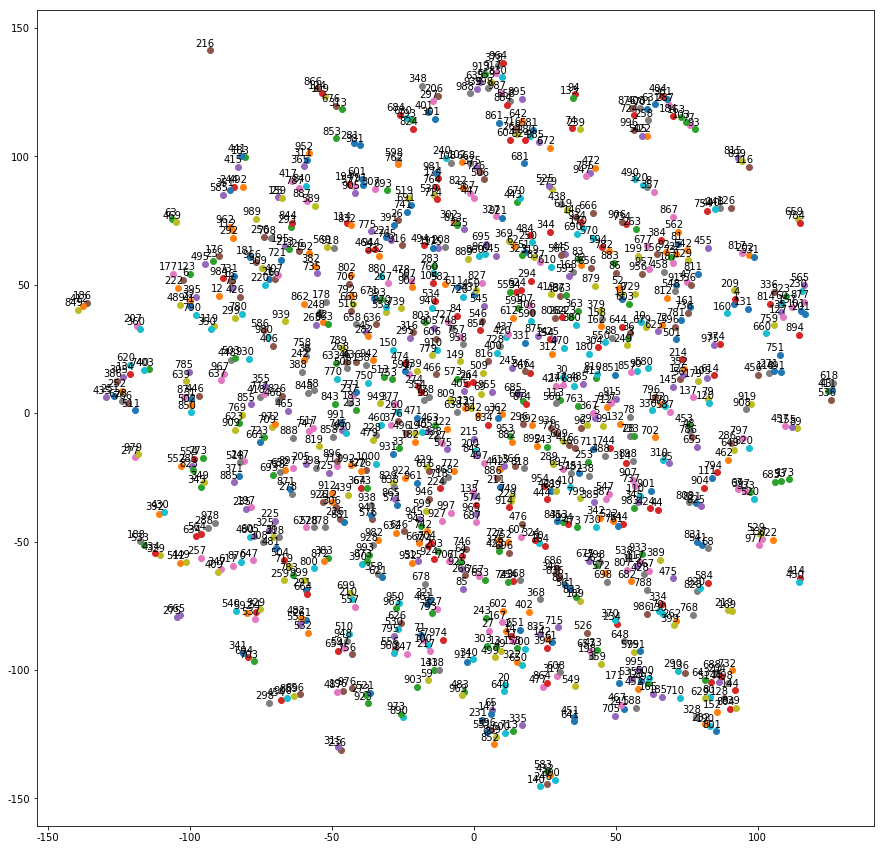

1 的
2 我
3 是
4 了
5 在
6 有
7 <go>
8 <eos>
9 也
10 就
11 都
12 不
13 你
14 他
15 很
16 會
17 她
18 說
19 跟
20 人
21 可以
22 但
23 要
24 看
25 想
26 好
27 自己
28 到
29 去
30 為
31 一個
32 沒有
33 被
34 因為
35 嗎
36 就是
37 讓
38 覺得
39 電影
40 和
41 沒
42 喜歡
43 什麼
44 還是
45 對
46 知道
47 所以
48 真的
49 妳
50 工作
51 如果
52 又
53 上
54 朋友
55 與
56 後
57 這
58 不是
59 這樣
60 吧
61 我們
62 希望
63 一起
64 公司
65 大家
66 能
67 中
68 多
69 做
70 女生
71 那
72 才
73 但是
74 nameid
75 不會
76 把
77 2
78 開始
79 現在
80 比較
81 而
82 應該
83 可能
84 感覺
85 時間
86 再
87 個
88 只是
89 或
90 時候
91 然後
92 不過
93 1
94 之
95 一下
96 來
97 看到
98 找
99 著
100 這個
101 啊
102 月
103 3
104 問題
105 最後
106 其實
107 雖然
108 年
109 大
110 一直
111 時
112 不要
113 用
114 請
115 女友
116 一
117 男友
118 怎麼
119 已經
120 目前
121 很多
122 等
123 還有
124 小
125 之後
126 一樣
127 呢
128 更
129 卻
130 男生
131 的話
132 從
133 引述
134 還
135 銘言
136 有點
137 最近
138 認識
139 吃
140 台灣
141 各位
142 他們
143 這種
144 最
145 前
146 約
147 以
148 像
149 打
150 發現
151 出來
152 太
153 對方
154 好像
155 或是
156 而且
157 啦
158 只
159 想要
160 得
161 結果
162 只有
163 4
164 生活
165 一些
166 完
167 小弟
168 一定
169 男
17

In [15]:
import tensorflow as tf
import numpy as np
import csv
import os
################################################################
# Load Embedding model
################################################################

str_epoch = 40
model_name = 'PTT_Words_Embedding_1523515706.365372'
mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

word2vector_graph = tf.Graph()
with tf.Session(graph=word2vector_graph) as sess:
    ######## Load model parameters ########
    # Load model and weight parameters
    load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
    loader = tf.train.import_meta_graph(load_model_dir + '.meta')
    loader.restore(sess, load_model_dir)
    # Load named input parameters
    embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
    norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
    normal_embeddings = embeddings / norm
        
'''    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())

    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())'''

from matplotlib.font_manager import FontProperties 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import pylab
from sklearn.manifold import TSNE
################################################################
# Build t-SNE dimensionality reduction for embeddings lookup.
################################################################

#font = FontProperties(fname= r'C:\windows\fonts\Microsoft JhengHei UI\msjh', size=10)
plt.rcParams['font.family']='msjh'#'Microsoft JhengHei UI' # 指定默認字體
plt.rcParams['axes.unicode_minus'] = False # 解決保存圖像是負號'-'顯示為方塊的問題

num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, method='exact')
two_d_embeddings = tsne.fit_transform(normal_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

#words = [vocab_reverse[i] for i in range(1, num_points+1)]
words = [i for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

for i in range(1, num_points+1):
    print(i, vocab_reverse[i])